In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy
!pip install matplotlib==3.1.3

     |████████████████████████████████| 2.0 MB 12.4 MB/s 
     |████████████████████████████████| 96 kB 978 kB/s 
     |████████████████████████████████| 11.2 MB 53.1 MB/s 
     |████████████████████████████████| 88 kB 7.5 MB/s 
     |████████████████████████████████| 930 kB 48.5 MB/s 
     |████████████████████████████████| 1.1 MB 53.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7f1a4d48ff4d313ffe4fdb010a62534dbbd9e03c8bd926271f87a555752b37dd
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=ce9a9f4737be5e877c066db4db4dbcbcd5bea323a789f12d36ead4d4ef6c4d4a
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for session-info: filename=session_info-1.0.0-py3-n

     |████████████████████████████████| 13.1 MB 9.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Importing required libraries 

In [ ]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Pancreatic Data 

## Data Treatment 

### Loading pancreatic data with cell cycle removed 

In [ ]:
# Pancreas_adata = sc.read_text('/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt', delimiter = '\t', first_column_names=None)
Pancreas_adata = sc.read_text("/content/drive/MyDrive/pancreatic_gbm/Pancreas_LogX_CellCycleRegressedOut.txt", delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata)
Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    var: 'mean', 'std'

### Reading 13 unique pancreatic cell types from metadata 

In [ ]:
# PancreasMetadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
PancreasMetadata = pd.read_csv("/content/drive/MyDrive/pancreatic_gbm/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

### Copying cell ids (which are 2209 in number) from metadata and saving it as rows in adata

In [ ]:
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID
Pancreas_adata.obs_names

Index(['HP1502401_H13', 'HP1502401_J14', 'HP1502401_B14', 'HP1502401_A14',
       'HP1502401_C14', 'HP1502401_G14', 'HP1502401_E14', 'HP1502401_L14',
       'HP1502401_M14', 'HP1502401_K14',
       ...
       'HP1526901T2D_M7', 'HP1526901T2D_N16', 'HP1526901T2D_C8',
       'HP1526901T2D_H2', 'HP1526901T2D_I16', 'HP1526901T2D_F7',
       'HP1525301T2D_K3', 'HP1525301T2D_J10', 'HP1526901T2D_N8',
       'HP1526901T2D_A8'],
      dtype='object', length=2209)

### Copying genes from genelist (which is of 26179) and saving it as columns in adata

In [ ]:
PancreasGenes = pd.read_csv("/content/drive/MyDrive/pancreatic_gbm/Pancreas_Genelist.txt",header=None)
# PancreasGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist
Pancreas_adata.var_names

Index(['SGIP1', 'AZIN2', 'CLIC4', 'AGBL4', 'NECAP2', 'SLC45A1', 'TGFBR3',
       'DBT', 'RFWD2', 'C1orf21',
       ...
       'KIR3DS1', 'KIR2DL5B', 'KIR2DS2', 'KIR2DS1', 'KIR2DL2', 'KIR2DL4',
       'KIR2DS3', 'KIR2DS2', 'BIVM-ERCC5', 'ERCC_30000:mix1_7500:mix2'],
      dtype='object', length=26179)

### Excluding cells with not well-defined gene markers/excluding cells with cell type assignments that are not well-defined 

In [ ]:
# Exclude cells with cell type assignments that are not well-defined 
# i.e. unclassified exocrine, unclassified endocrine, co-expression, MHC
Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'unclassified exocrine'))[0,:],:]
Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'unclassified endocrine'))[0,:],:]
Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'co-expression'))[0,:],:]
Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'MHC'))[0,:],:]

print(Pancreas_adata.shape)
Pancreas_adata.obs['Cell Type'].unique()

(2122, 26179)


array(['γ', 'α', 'β', 'acinar', 'ε', 'ductal', 'δ', 'endothelial', 'PSC',
       'mast'], dtype=object)

### Reading all of PangloaDB marker gene list 

In [ ]:
MarkerGeneList = pd.read_csv("/content/drive/MyDrive/pancreatic_gbm/PanglaoDB_Markers.tsv",sep='\t')

### Subsetting Panglao DB database for organ pancreas and species human 

In [ ]:
PancreasMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['organ'] == 'Pancreas') & (MarkerGeneList['species'] != 'Mm')))[0,:],:]
PancreasMarkers

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
0,Mm Hs,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920
1,Mm Hs,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826
2,Mm Hs,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000
3,Mm Hs,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773
5,Mm Hs,CELA3A,Acinar cells,ELA3|ELA3A,0.001,chymotrypsin like elastase family member 3A,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.128571,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6374,Mm Hs,LRRTM1,Peri-islet Schwann cells,FLJ32082,0.005,leucine rich repeat transmembrane neuronal 1,protein-coding gene,NaN,Endoderm,Pancreas,0.000000,0.300000,0.001567,0.006292
6375,Mm Hs,SEMA3B,Peri-islet Schwann cells,SemA|semaV|LUCA-1|sema5|SEMAA,0.009,semaphorin 3B,protein-coding gene,NaN,Endoderm,Pancreas,1.000000,0.000000,0.017549,0.000000
6376,Mm Hs,NGFR,Peri-islet Schwann cells,TNFRSF16|CD271|p75NTR,0.007,nerve growth factor receptor,protein-coding gene,NaN,Endoderm,Pancreas,1.000000,1.000000,0.001880,0.006806
6377,Mm Hs,PNLIPRP1,Peri-islet Schwann cells,PLRP1,0.008,pancreatic lipase related protein 1,protein-coding gene,NaN,Endoderm,Pancreas,0.000000,0.200000,0.001880,0.009310


### Unqiue cell types for all data from panglao

In [ ]:
pd.unique(MarkerGeneList['cell type'])

array(['Acinar cells', 'Adipocyte progenitor cells', 'Adipocytes',
       'Adrenergic neurons', 'Airway epithelial cells',
       'Airway goblet cells', 'Airway smooth muscle cells', 'Alpha cells',
       'Alveolar macrophages', 'Anterior pituitary gland cells',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive',
       'Basal cells', 'Basophils', 'Bergmann glia', 'Beta cells',
       'Cajal-Retzius cells', 'Cardiac stem and precursor cells',
       'Cardiomyocytes', 'Cholangiocytes', 'Cholinergic neurons',
       'Chondrocytes', 'Choroid plexus cells', 'Chromaffin cells',
       'Ciliated cells', 'Clara cells', 'Crypt cells', 'Decidual cells',
       'Delta cells', 'Dendritic cells', 'Distal tubule cells',
       'Dopaminergic neurons', 'Ductal cells', 'Embryonic stem cells',
       'Endothelial cells', 'Endothelial cells (aorta)',
       'Endothelial cells (blood brain barrier)', 'Enteric glia cells',
       'Enteric neurons', 'Enterochromaffin cells', 'Enterocytes',
 

### Unique cell types for all data from panglao subsetted for pancreas and species human 

In [ ]:
pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic progenitor cells', 'Pancreatic stellate cells',
       'Peri-islet Schwann cells'], dtype=object)

In [ ]:
# Reading rows depicting unqiue cell types in pancreas_adata object 
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'ductal', 'δ', 'endothelial', 'PSC',
       'mast'], dtype=object)

### Manually manipulating Marker Gene List 

In [ ]:
# Manually get rid of unwanted cell types: Pancreatic progenitor cells and Peri-islet Schwann cells 
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Pancreatic progenitor cells'))[0,:],:]
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Peri-islet Schwann cells'))[0,:],:]

# Manually add cell types: endocrine, endothelial, mast, MHC (dendritic, macrophages, B cells)
# unclassified exocrine cells are also acinar cells; co-expression is not a defined cell type
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Enteroendocrine cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Endothelial cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Mast cells'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Dendritic cells'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Macrophages'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'B cells'))[0,:],:])

pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic stellate cells', 'Endothelial cells', 'Mast cells'],
      dtype=object)

### Showing that 587 genes are overlapping between our data and panglao db

In [ ]:
# Pancreas Markers = marker gene list subsetted for organ pancreas and species human, unwanted cell types removed 
PanglaoDB_Pancreas = PancreasMarkers['official gene symbol']
PanglaoDB_Pancreas = list(set(PanglaoDB_Pancreas) & set(Pancreas_adata.var_names)) # overlap between dataset gene list and the PanglaoDB set 
len(PanglaoDB_Pancreas)

587

In [ ]:
# Pancreas_adata.write(filename="/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_CellCycleRegressedOut_AnnData.h5ad")

In [ ]:
# Create a variable list for input genes / features 

Panglao_Input = []

for i in range(Pancreas_adata.shape[1]):
  if Pancreas_adata.var_names[i] in set(PanglaoDB_Pancreas):
    Panglao_Input.append(True)
  else: 
    Panglao_Input.append(False)

Pancreas_adata.var['input_features'] = Panglao_Input
Pancreas_adata.var['input_features']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SGIP1                        False
AZIN2                        False
CLIC4                         True
AGBL4                        False
NECAP2                       False
                             ...  
KIR2DL4                      False
KIR2DS3                      False
KIR2DS2                      False
BIVM-ERCC5                   False
ERCC_30000:mix1_7500:mix2    False
Name: input_features, Length: 26179, dtype: bool

In [ ]:
# Create anndata input for the model by filtering Pancreas_adata

Pancreas_input = Pancreas_adata[:,Pancreas_adata.var['input_features']]
Pancreas_input


View of AnnData object with n_obs × n_vars = 2122 × 593
    obs: 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# device = 'cpu'

cuda


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Sparse Model with zero weights for non-marker gene connections 

### Creating autoencoder model 

In [ ]:
# same structure as pytorch model with no enforced barriers on weights 
class Autoencoder(Model):
    def __init__(self, num_cell_types, num_genes, weight_mask):
        super(Autoencoder, self).__init__()  
        self.weight_mask = weight_mask 
        self.encoder = tf.keras.Sequential([
          layers.Dense(num_cell_types, activation='softmax', kernel_constraint=NonNegative(self.weight_mask))])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def embed(self, x):
      encoded = self.encoder(x)
      return encoded

### Creating weight mask for marker genes

Since the weight mask is only for marker genes, the mask will be zero for non-marker genes.

In [ ]:
marker_genes = Pancreas_input.var_names
cell_types = pd.unique(PancreasMarkers['cell type'])

marker_gene_cell_type_weight_mask = np.zeros((len(marker_genes), len(cell_types)))
for i, gene in enumerate(marker_genes):
  for j, cell_type in enumerate(cell_types):
    is_marker_gene_for_cell_type = \
      PancreasMarkers[(PancreasMarkers['official gene symbol'] == gene) & 
                      (PancreasMarkers['cell type'] == cell_type)].shape[0] > 0
    if is_marker_gene_for_cell_type:   # Mask = 1
      marker_gene_cell_type_weight_mask[i, j] = 1
    else:                              # Mask = 0
      marker_gene_cell_type_weight_mask[i, j] = 0

print(marker_gene_cell_type_weight_mask.shape)
marker_gene_cell_type_weight_mask

(593, 10)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Creating Keras Layer constraint 

We create the constraint in such a way that the weight matrix is multiplied with the weight mask. The non-marker gene weights are masked by making them zero. 

In [ ]:
class NonNegative(tf.keras.constraints.Constraint):

  def __init__(self, weight_mask):
    self.weight_mask = weight_mask

# Multiply the weight matrix by weight mask

  def __call__(self, w):
    return w * self.weight_mask

 ### Fitting the model for 100 epochs. 

In [ ]:
NumPancreasCellTypes = len(Pancreas_adata.obs['Cell Type'].unique())
num_genes = Pancreas_input.shape[1]
autoencoder = Autoencoder(NumPancreasCellTypes, num_genes, 
                          marker_gene_cell_type_weight_mask)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(Pancreas_input.X, Pancreas_input.X,
                          epochs=100,
                          shuffle=True,
                          validation_data=(Pancreas_input.X, Pancreas_input.X))

Epoch 1/100
67/67 [==============================] - 3s 7ms/step - loss: 0.9715 - val_loss: 0.9555
Epoch 2/100
67/67 [==============================] - 0s 4ms/step - loss: 0.9374 - val_loss: 0.9188
Epoch 3/100
67/67 [==============================] - 0s 4ms/step - loss: 0.9044 - val_loss: 0.8898
Epoch 4/100
67/67 [==============================] - 0s 4ms/step - loss: 0.8785 - val_loss: 0.8666
Epoch 5/100
67/67 [==============================] - 0s 5ms/step - loss: 0.8574 - val_loss: 0.8475
Epoch 6/100
67/67 [==============================] - 0s 5ms/step - loss: 0.8396 - val_loss: 0.8310
Epoch 7/100
67/67 [==============================] - 0s 5ms/step - loss: 0.8244 - val_loss: 0.8171
Epoch 8/100
67/67 [==============================] - 0s 5ms/step - loss: 0.8113 - val_loss: 0.8048
Epoch 9/100
67/67 [==============================] - 0s 4ms/step - loss: 0.7998 - val_loss: 0.7942
Epoch 10/100
67/67 [==============================] - 0s 5ms/step - loss: 0.7897 - val_loss: 0.7847
Epoch 11/

### Plotting training loss 

Text(0.5, 0, 'Epochs')

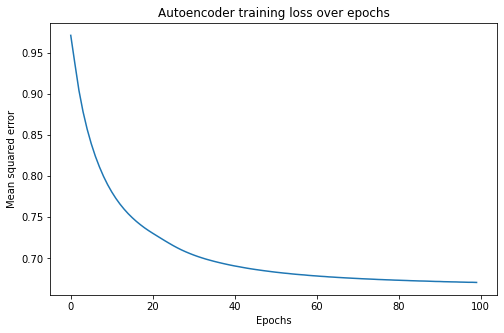

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Autoencoder training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

### Predicting Cell Types 

These would be the predictions for the Custom Sparse Model with zero weights for non-marker gene connections 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


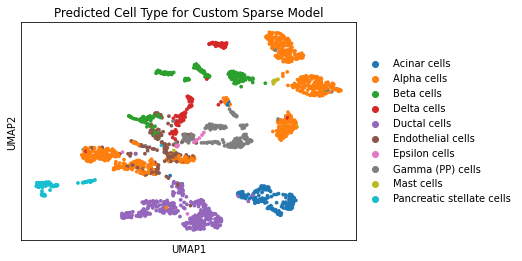

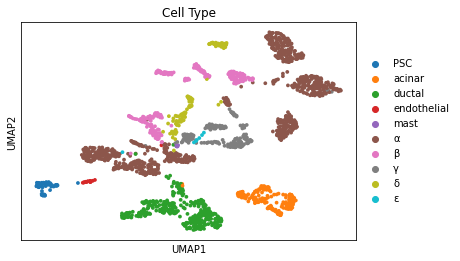

In [ ]:
latent_embedding = autoencoder.embed(Pancreas_input.X)
cell_type_labels = [cell_types[label] for label in 
                    tf.math.argmax(latent_embedding, axis=1).numpy()]

sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

Pancreas_adata.obs['Predicted Cell Type for Custom Sparse Model'] = cell_type_labels
# Pancreas_adata.obs['Predicted Cell Type'] = cell_type_labels
sc.pl.umap(Pancreas_adata, color=['Predicted Cell Type for Custom Sparse Model'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

### Exporting predictions 

In [ ]:
dir = '/content/drive/MyDrive/pancreatic_gbm/regularized_models/'
Pancreas_adata.obs.to_csv(dir + 'keras_zero_weight_kernel_constraint.csv')

# GBM Data 

## Data Treatment 

In [ ]:
# Read and process GBM data 


GBM_adata = sc.read_text("/content/drive/MyDrive/processed_gbm_data/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

# Regress out cell cycle scores
GBMCellCycleScores = pd.read_table("/content/drive/MyDrive/processed_gbm_data/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

GBM_Metadata = pd.read_csv("/content/drive/MyDrive/processed_gbm_data/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

GBMGenes = pd.read_csv("/content/drive/MyDrive/processed_gbm_data/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

### Manually manipulating Marker Gene List for GBM data 

In [ ]:
GBMMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['cell type'] == 'Oligodendrocytes') | 
                                                    (MarkerGeneList['cell type'] == 'T cells') |
                                                    (MarkerGeneList['cell type'] == 'Macrophages')))[0,:],:]

PanglaoDB_GBM = GBMMarkers['official gene symbol']
PanglaoDB_GBM = list(set(PanglaoDB_GBM) & set(GBM_adata.var_names))

# # Manually add malignant gene markers 
# MalignantGenes = ['CD133','CD44','ABCC3','TNFRSF1A','MGMT','IDH 1','IDH 2','ATRX','1p/19q','TP53','RB','PI3K','RKT','RAS','TERT']
# for g in MalignantGenes:
#   if ((g in GBM_adata.var_names) & (g not in PanglaoDB_GBM)):
#     PanglaoDB_GBM.append(g)

# Manually add malignant gene markers 
MalignantGenesPool = ['CD133','CD44','ABCC3','TNFRSF1A','MGMT','IDH 1','IDH 2','ATRX','1p/19q','TP53','RB','PI3K','RKT','RAS','TERT']
MalignantGenes = []
for g in MalignantGenesPool:
  if ((g in GBM_adata.var_names) & (g not in PanglaoDB_GBM)):
    MalignantGenes.append(g)
MalignantGenes

# Create a variable list for input genes / features 
Panglao_GBM_Input = []

for i in range(GBM_adata.shape[1]):
  if GBM_adata.var_names[i] in set(PanglaoDB_GBM):
    Panglao_GBM_Input.append(True)
  else: 
    Panglao_GBM_Input.append(False)

GBM_adata.var['input_features'] = Panglao_GBM_Input

In [ ]:
Malignant_df = pd.DataFrame({"official gene symbol":MalignantGenes, "cell type":['Malignant']*len(MalignantGenes)})
Malignant_df

,official gene symbol,cell type
0,CD44,Malignant
1,ABCC3,Malignant
2,TNFRSF1A,Malignant
3,MGMT,Malignant
4,ATRX,Malignant
5,TP53,Malignant
6,TERT,Malignant


In [ ]:
len(PanglaoDB_GBM)

295

In [ ]:
PanglaoDB_GBM = PanglaoDB_GBM + list(Malignant_df['official gene symbol'])
len(PanglaoDB_GBM)

302

In [ ]:
GBMMarkers_list = []
for gene in PanglaoDB_GBM:
  if gene in list(GBMMarkers['official gene symbol']):
    GBMMarkers_list.append({
        'official gene symbol': gene,
        'cell type': GBMMarkers.loc[GBMMarkers['official gene symbol'] == gene, 'cell type'].iloc[0]
    })
        
GBMMarkers = pd.DataFrame(GBMMarkers_list)
print(GBMMarkers.shape)
GBMMarkers.head()

(295, 2)


,official gene symbol,cell type
0,CD180,Macrophages
1,EFNB3,Oligodendrocytes
2,LAG3,T cells
3,NAAA,Macrophages
4,CCR7,Macrophages


In [ ]:
GBMMarkers = pd.concat([GBMMarkers, Malignant_df])
print(GBMMarkers.shape)
GBMMarkers.head()

(302, 2)


,official gene symbol,cell type
0,CD180,Macrophages
1,EFNB3,Oligodendrocytes
2,LAG3,T cells
3,NAAA,Macrophages
4,CCR7,Macrophages


In [ ]:
# Create a variable list for input genes / features 
Panglao_GBM_Input = []

for i in range(GBM_adata.shape[1]):
  if GBM_adata.var_names[i] in PanglaoDB_GBM:
    Panglao_GBM_Input.append(True)
  else: 
    Panglao_GBM_Input.append(False)

GBM_adata.var['input_features'] = Panglao_GBM_Input

In [ ]:
# Create anndata input for the model by filtering GBM_adata
GBM_input = GBM_adata[:,GBM_adata.var['input_features']]
GBM_input

View of AnnData object with n_obs × n_vars = 7930 × 302
    obs: 'score_S', 'score_G2M', 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [ ]:
cell_types = pd.unique(GBMMarkers['cell type'])
cell_types

array(['Macrophages', 'Oligodendrocytes', 'T cells', 'Malignant'],
      dtype=object)

## Model Creation 

### Creating weight mask for marker genes 

In [ ]:
marker_genes = GBM_input.var_names
cell_types = pd.unique(GBMMarkers['cell type'])

marker_gene_cell_type_weight_mask = np.zeros((len(marker_genes), len(cell_types)))
for i, gene in enumerate(marker_genes):
  for j, cell_type in enumerate(cell_types):
    is_marker_gene_for_cell_type = \
      GBMMarkers[(GBMMarkers['official gene symbol'] == gene) & 
                      (GBMMarkers['cell type'] == cell_type)].shape[0] > 0
    if is_marker_gene_for_cell_type:   # Mask = 1
      marker_gene_cell_type_weight_mask[i, j] = 1
    else:                              # Mask = 0
      marker_gene_cell_type_weight_mask[i, j] = 0

print(marker_gene_cell_type_weight_mask.shape)
marker_gene_cell_type_weight_mask

(302, 4)


array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

### Creating Keras Layer constraint 

In [ ]:
class NonNegative(tf.keras.constraints.Constraint):

  def __init__(self, weight_mask):
    self.weight_mask = weight_mask

# Multiply the weight matrix by weight mask

  def __call__(self, w):
    return w * self.weight_mask

### Fitting the model for 100 epochs 

In [ ]:
NumGBMCellTypes = len(GBM_input.obs['Cell Type'].unique())
num_genes = GBM_input.shape[1]
autoencoder = Autoencoder(NumGBMCellTypes, num_genes, 
                          marker_gene_cell_type_weight_mask)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(GBM_input.X, GBM_input.X,
                          epochs=100,
                          shuffle=True,
                          validation_data=(GBM_input.X, GBM_input.X))

Epoch 1/100
248/248 [==============================] - 2s 5ms/step - loss: 0.9776 - val_loss: 0.9475
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 0.9269 - val_loss: 0.9085
Epoch 3/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8953 - val_loss: 0.8827
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8732 - val_loss: 0.8638
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8568 - val_loss: 0.8498
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8446 - val_loss: 0.8390
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8349 - val_loss: 0.8302
Epoch 8/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8265 - val_loss: 0.8221
Epoch 9/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8189 - val_loss: 0.8150
Epoch 10/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8123 - val_lo

### Plotting training loss 

Text(0.5, 0, 'Epochs')

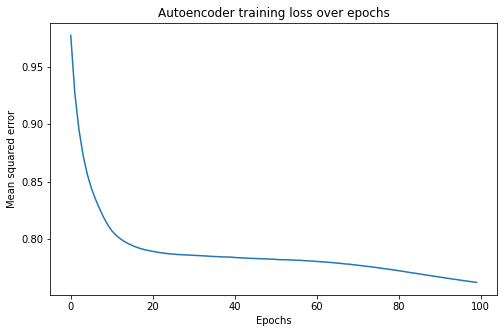

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Autoencoder training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

### Predicting cell types 

In [ ]:
import umap

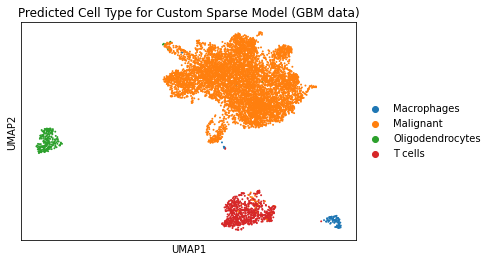

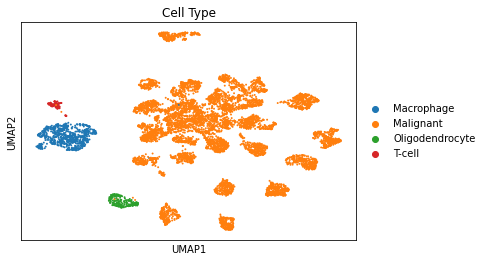

In [ ]:
latent_embedding = autoencoder.embed(GBM_input.X)
cell_type_labels = [cell_types[label] for label in 
                    tf.math.argmax(latent_embedding, axis=1).numpy()]

sc.tl.pca(GBM_input, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(GBM_input, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_input)

GBM_input.obs['Predicted Cell Type for Custom Sparse Model (GBM data) '] = cell_type_labels
sc.pl.umap(GBM_input, color=['Predicted Cell Type for Custom Sparse Model (GBM data)'])
sc.pl.umap(GBM_adata, color=['Cell Type'])

### Exporting predictions 

In [ ]:
dir = '/content/drive/MyDrive/pancreatic_gbm/regularized_models/'
GBM_input.obs.to_csv(dir + 'keras_zero_weight_kernel_constraint_GBM.csv')